# Dataset

In [13]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# Remove filler words

In [14]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [15]:
corpus = remove_stop_words(corpus)

In [16]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

In [17]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

# Skip-Gram model

In [19]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [20]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [21]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [22]:
df.shape

(52, 2)

In [23]:
word2int

{'boy': 10,
 'girl': 4,
 'king': 9,
 'man': 11,
 'pretty': 1,
 'prince': 5,
 'princess': 8,
 'queen': 2,
 'strong': 0,
 'wise': 7,
 'woman': 3,
 'young': 6}

# TensorFlow implementation

In [24]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = []
Y = [] 

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

X_train = np.asarray(X)
Y_train = np.asarray(Y)

x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))


EMBEDDING_DIM = 2 


W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)


W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1])) # cross entropy

train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

# Train

In [26]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 2000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  2.8113
iteration 2000 loss is :  2.03961
iteration 4000 loss is :  1.84057
iteration 6000 loss is :  1.79117
iteration 8000 loss is :  1.76422
iteration 10000 loss is :  1.75066
iteration 12000 loss is :  1.74183
iteration 14000 loss is :  1.73519
iteration 16000 loss is :  1.72984
iteration 18000 loss is :  1.72534


## Word lookup table in the hidden layer

In [27]:
vectors = sess.run(W1 + b1)
print(vectors)

[[-4.04184771  3.94697809]
 [ 2.69520903  2.63248348]
 [ 1.13378584  0.67759454]
 [ 1.10412765  0.21108496]
 [ 2.67590618  2.08185387]
 [-2.28118944  5.28326416]
 [-0.09887433  0.0857619 ]
 [ 4.83490562  3.02300072]
 [ 4.33428812  2.24532628]
 [-0.53716111  0.35886669]
 [-0.73348641  0.6195659 ]
 [-1.24692214  3.2703414 ]]


In [28]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,strong,-4.041848,3.946978
1,pretty,2.695209,2.632483
2,queen,1.133786,0.677595
3,woman,1.104128,0.211085
4,girl,2.675906,2.081854
5,prince,-2.281189,5.283264
6,young,-0.098874,0.085762
7,wise,4.834906,3.023001
8,princess,4.334288,2.245326
9,king,-0.537161,0.358867


# Plot to a 2D Chart

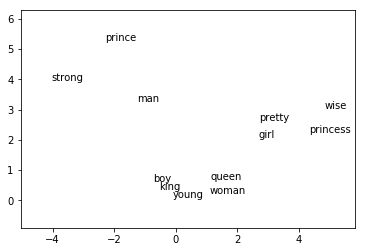

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()